#CNN-LSTM Cryptocurrency Pairs Trading Project

Based on "An Advanced CNN-LSTM Model for Cryptocurrency Forecasting" by Livieris et al.

This project implements the MICDL (Multiple-Input Cryptocurrency Deep Learning) model
for pairs trading between Bitcoin (BTC), Ethereum (ETH), and Ripple (XRP).
"""

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.regression.linear_model import OLS
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, concatenate
import warnings
warnings.filterwarnings('ignore')

In [21]:
class CNNLSTMPairsTradingStrategy:
    """
    Pairs Trading Strategy combining CNN-LSTM forecasting with cointegration analysis
    Based on the MICDL model architecture from the paper
    """

    def __init__(self, lookback_window=14, entry_threshold=2.0, exit_threshold=0.5):
        self.lookback_window = lookback_window
        self.entry_threshold = entry_threshold  # Z-score threshold for entry
        self.exit_threshold = exit_threshold    # Z-score threshold for exit
        self.model = None
        self.scaler_btc = MinMaxScaler()
        self.scaler_eth = MinMaxScaler()
        self.hedge_ratio = None
        self.spread_mean = None
        self.spread_std = None

    def create_micdl_model(self, input_shape):
        """
        Create the Multiple-Input Cryptocurrency Deep Learning (MICDL) model
        as described in the paper
        """
        # Input layers for BTC and ETH
        btc_input = Input(shape=input_shape, name='btc_input')
        eth_input = Input(shape=input_shape, name='eth_input')

        # BTC processing branch
        btc_conv = Conv1D(filters=16, kernel_size=2, activation='relu')(btc_input)
        btc_pool = MaxPooling1D(pool_size=2)(btc_conv)
        btc_lstm = LSTM(50, return_sequences=False)(btc_pool)

        # ETH processing branch
        eth_conv = Conv1D(filters=16, kernel_size=2, activation='relu')(eth_input)
        eth_pool = MaxPooling1D(pool_size=2)(eth_conv)
        eth_lstm = LSTM(50, return_sequences=False)(eth_pool)

        # Concatenate the outputs
        concatenated = concatenate([btc_lstm, eth_lstm])

        # Dense layers for final processing
        dense1 = Dense(256, activation='relu')(concatenated)
        batch_norm1 = BatchNormalization()(dense1)
        dropout1 = Dropout(0.3)(batch_norm1)

        dense2 = Dense(64, activation='relu')(dropout1)
        batch_norm2 = BatchNormalization()(dense2)
        dropout2 = Dropout(0.2)(batch_norm2)

        # Output layers for BTC and ETH predictions
        btc_output = Dense(1, activation='linear', name='btc_output')(dropout2)
        eth_output = Dense(1, activation='linear', name='eth_output')(dropout2)

        model = Model(inputs=[btc_input, eth_input],
                     outputs=[btc_output, eth_output])

        model.compile(optimizer='rmsprop',
                     loss={'btc_output': 'mse', 'eth_output': 'mse'},
                     metrics=['mae'])

        return model

    def prepare_data(self, btc_prices, eth_prices):
        """
        Prepare data for training including returns transformation for stationarity
        """
        # Calculate returns for stationarity (as mentioned in the paper)
        btc_returns = btc_prices.pct_change().dropna()
        eth_returns = eth_prices.pct_change().dropna()

        # Align the data
        min_length = min(len(btc_returns), len(eth_returns))
        btc_returns = btc_returns[-min_length:]
        eth_returns = eth_returns[-min_length:]

        # Scale the returns
        btc_scaled = self.scaler_btc.fit_transform(btc_returns.values.reshape(-1, 1))
        eth_scaled = self.scaler_eth.fit_transform(eth_returns.values.reshape(-1, 1))

        return btc_scaled.flatten(), eth_scaled.flatten(), btc_returns.index

    def create_sequences(self, btc_data, eth_data, lookback):
        """
        Create sequences for CNN-LSTM training
        """
        X_btc, X_eth, y_btc, y_eth = [], [], [], []

        for i in range(lookback, len(btc_data)):
            X_btc.append(btc_data[i-lookback:i])
            X_eth.append(eth_data[i-lookback:i])
            y_btc.append(btc_data[i])
            y_eth.append(eth_data[i])

        return (np.array(X_btc).reshape(-1, lookback, 1),
                np.array(X_eth).reshape(-1, lookback, 1),
                np.array(y_btc),
                np.array(y_eth))

    def train_model(self, btc_prices, eth_prices, epochs=100, validation_split=0.2):
        """
        Train the MICDL model
        """
        # Prepare data
        btc_scaled, eth_scaled, dates = self.prepare_data(btc_prices, eth_prices)

        # Create sequences
        X_btc, X_eth, y_btc, y_eth = self.create_sequences(
            btc_scaled, eth_scaled, self.lookback_window)

        # Create model
        input_shape = (self.lookback_window, 1)
        self.model = self.create_micdl_model(input_shape)

        # Train model
        history = self.model.fit(
            [X_btc, X_eth],
            [y_btc, y_eth],
            epochs=epochs,
            validation_split=validation_split,
            batch_size=32,
            verbose=1
        )

        return history

    def predict_returns(self, btc_recent, eth_recent):
        """
        Predict next period returns using trained CNN-LSTM model
        """
        if self.model is None:
            raise ValueError("Model must be trained first")

        # Scale recent data
        btc_scaled = self.scaler_btc.transform(btc_recent.reshape(-1, 1)).flatten()
        eth_scaled = self.scaler_eth.transform(eth_recent.reshape(-1, 1)).flatten()

        # Prepare sequences
        X_btc = btc_scaled[-self.lookback_window:].reshape(1, self.lookback_window, 1)
        X_eth = eth_scaled[-self.lookback_window:].reshape(1, self.lookback_window, 1)

        # Predict
        btc_pred, eth_pred = self.model.predict([X_btc, X_eth])

        # Inverse transform
        btc_pred_return = self.scaler_btc.inverse_transform(btc_pred.reshape(-1, 1))[0, 0]
        eth_pred_return = self.scaler_eth.inverse_transform(eth_pred.reshape(-1, 1))[0, 0]

        return btc_pred_return, eth_pred_return

    def test_cointegration(self, btc_prices, eth_prices, significance_level=0.05):
        """
        Test for cointegration between BTC and ETH using Engle-Granger test
        """
        # Ensure same length
        min_length = min(len(btc_prices), len(eth_prices))
        btc_aligned = btc_prices[-min_length:]
        eth_aligned = eth_prices[-min_length:]

        # Perform cointegration test
        coint_stat, p_value, critical_values = coint(btc_aligned, eth_aligned)

        is_cointegrated = p_value < significance_level

        return {
            'is_cointegrated': is_cointegrated,
            'p_value': p_value,
            'coint_stat': coint_stat,
            'critical_values': critical_values
        }

    def estimate_hedge_ratio(self, btc_prices, eth_prices):
        """
        Estimate hedge ratio using OLS regression
        """
        # Ensure same length
        min_length = min(len(btc_prices), len(eth_prices))
        btc_aligned = btc_prices[-min_length:]
        eth_aligned = eth_prices[-min_length:]

        # Run regression: BTC = alpha + beta * ETH + error
        model = OLS(btc_aligned, np.column_stack([np.ones(len(eth_aligned)), eth_aligned]))
        results = model.fit()

        self.hedge_ratio = results.params[1]  # Beta coefficient
        return self.hedge_ratio, results

    def calculate_spread(self, btc_prices, eth_prices):
        """
        Calculate the spread: BTC - hedge_ratio * ETH
        """
        if self.hedge_ratio is None:
            raise ValueError("Hedge ratio must be estimated first")

        spread = btc_prices - self.hedge_ratio * eth_prices
        return spread

    def calculate_zscore(self, spread, window=30):
        """
        Calculate rolling z-score of the spread
        """
        rolling_mean = spread.rolling(window=window).mean()
        rolling_std = spread.rolling(window=window).std()
        zscore = (spread - rolling_mean) / rolling_std
        return zscore

    def generate_signals(self, btc_prices, eth_prices, btc_predictions, eth_predictions):
        """
        Generate trading signals based on cointegration and CNN-LSTM predictions
        """
        # Calculate current spread and z-score
        spread = self.calculate_spread(btc_prices, eth_prices)
        zscore = self.calculate_zscore(spread)

        # Predict future prices using CNN-LSTM predictions
        current_btc = btc_prices.iloc[-1]
        current_eth = eth_prices.iloc[-1]

        predicted_btc = current_btc * (1 + btc_predictions)
        predicted_eth = current_eth * (1 + eth_predictions)

        # Calculate predicted spread
        predicted_spread = predicted_btc - self.hedge_ratio * predicted_eth
        current_spread = spread.iloc[-1]

        # Generate signals
        signals = pd.DataFrame(index=btc_prices.index)
        signals['btc_position'] = 0
        signals['eth_position'] = 0
        signals['spread'] = spread
        signals['zscore'] = zscore

        # Current z-score
        current_zscore = zscore.iloc[-1]

        # Trading logic combining mean reversion and momentum
        if current_zscore > self.entry_threshold:
            # Spread is too high, expect mean reversion
            # Short BTC, Long ETH
            if predicted_spread < current_spread:  # CNN-LSTM confirms mean reversion
                signals['btc_position'].iloc[-1] = -1
                signals['eth_position'].iloc[-1] = self.hedge_ratio

        elif current_zscore < -self.entry_threshold:
            # Spread is too low, expect mean reversion
            # Long BTC, Short ETH
            if predicted_spread > current_spread:  # CNN-LSTM confirms mean reversion
                signals['btc_position'].iloc[-1] = 1
                signals['eth_position'].iloc[-1] = -self.hedge_ratio

        # Exit signals
        if abs(current_zscore) < self.exit_threshold:
            signals['btc_position'].iloc[-1] = 0
            signals['eth_position'].iloc[-1] = 0

        return signals

    def backtest_strategy(self, btc_prices, eth_prices, initial_capital=100000):
        """
        Backtest the pairs trading strategy
        """
        # Test cointegration
        coint_result = self.test_cointegration(btc_prices, eth_prices)
        print(f"Cointegration test p-value: {coint_result['p_value']:.4f}")

        if not coint_result['is_cointegrated']:
            print("Warning: BTC and ETH may not be cointegrated!")

        # Estimate hedge ratio
        hedge_ratio, ols_results = self.estimate_hedge_ratio(btc_prices, eth_prices)
        print(f"Estimated hedge ratio: {hedge_ratio:.4f}")

        # Calculate spread and z-score
        spread = self.calculate_spread(btc_prices, eth_prices)
        zscore = self.calculate_zscore(spread)

        # Initialize portfolio
        portfolio = pd.DataFrame(index=btc_prices.index)
        portfolio['btc_holdings'] = 0.0
        portfolio['eth_holdings'] = 0.0
        portfolio['cash'] = initial_capital
        portfolio['total_value'] = initial_capital
        portfolio['returns'] = 0.0

        # Trading signals based on z-score (traditional pairs trading)
        for i in range(1, len(portfolio)):
            current_zscore = zscore.iloc[i]
            prev_zscore = zscore.iloc[i-1]

            btc_price = btc_prices.iloc[i]
            eth_price = eth_prices.iloc[i]

            # Copy previous positions
            portfolio['btc_holdings'].iloc[i] = portfolio['btc_holdings'].iloc[i-1]
            portfolio['eth_holdings'].iloc[i] = portfolio['eth_holdings'].iloc[i-1]
            portfolio['cash'].iloc[i] = portfolio['cash'].iloc[i-1]

            # Entry signals
            if abs(prev_zscore) < self.entry_threshold and current_zscore > self.entry_threshold:
                # Enter short spread position
                trade_size = initial_capital * 0.1  # Risk 10% of capital per trade
                btc_shares = -trade_size / btc_price
                eth_shares = trade_size * hedge_ratio / eth_price

                portfolio['btc_holdings'].iloc[i] += btc_shares
                portfolio['eth_holdings'].iloc[i] += eth_shares
                portfolio['cash'].iloc[i] -= (btc_shares * btc_price + eth_shares * eth_price)

            elif abs(prev_zscore) < self.entry_threshold and current_zscore < -self.entry_threshold:
                # Enter long spread position
                trade_size = initial_capital * 0.1
                btc_shares = trade_size / btc_price
                eth_shares = -trade_size * hedge_ratio / eth_price

                portfolio['btc_holdings'].iloc[i] += btc_shares
                portfolio['eth_holdings'].iloc[i] += eth_shares
                portfolio['cash'].iloc[i] -= (btc_shares * btc_price + eth_shares * eth_price)

            # Exit signals
            elif abs(current_zscore) < self.exit_threshold and abs(prev_zscore) > self.exit_threshold:
                # Close all positions
                portfolio['cash'].iloc[i] += (portfolio['btc_holdings'].iloc[i] * btc_price +
                                            portfolio['eth_holdings'].iloc[i] * eth_price)
                portfolio['btc_holdings'].iloc[i] = 0
                portfolio['eth_holdings'].iloc[i] = 0

            # Calculate total portfolio value
            portfolio['total_value'].iloc[i] = (portfolio['cash'].iloc[i] +
                                              portfolio['btc_holdings'].iloc[i] * btc_price +
                                              portfolio['eth_holdings'].iloc[i] * eth_price)

            # Calculate returns
            portfolio['returns'].iloc[i] = (portfolio['total_value'].iloc[i] /
                                          portfolio['total_value'].iloc[i-1] - 1)

        return portfolio, spread, zscore

    def plot_results(self, btc_prices, eth_prices, portfolio, spread, zscore):
        """
        Plot backtest results
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Plot 1: Price series
        axes[0, 0].plot(btc_prices.index, btc_prices, label='BTC', alpha=0.7)
        axes[0, 0].plot(eth_prices.index, eth_prices, label='ETH', alpha=0.7)
        axes[0, 0].set_title('BTC and ETH Prices')
        axes[0, 0].set_ylabel('Price (USD)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Plot 2: Spread and Z-score
        ax2 = axes[0, 1]
        ax2.plot(spread.index, spread, label='Spread', color='blue', alpha=0.7)
        ax2.set_ylabel('Spread', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')

        ax2_twin = ax2.twinx()
        ax2_twin.plot(zscore.index, zscore, label='Z-score', color='red', alpha=0.7)
        ax2_twin.axhline(self.entry_threshold, color='red', linestyle='--', alpha=0.5)
        ax2_twin.axhline(-self.entry_threshold, color='red', linestyle='--', alpha=0.5)
        ax2_twin.axhline(self.exit_threshold, color='green', linestyle='--', alpha=0.5)
        ax2_twin.axhline(-self.exit_threshold, color='green', linestyle='--', alpha=0.5)
        ax2_twin.set_ylabel('Z-score', color='red')
        ax2_twin.tick_params(axis='y', labelcolor='red')
        ax2.set_title('Spread and Z-score')
        ax2.grid(True, alpha=0.3)

        # Plot 3: Portfolio value
        axes[1, 0].plot(portfolio.index, portfolio['total_value'])
        axes[1, 0].set_title('Portfolio Value')
        axes[1, 0].set_ylabel('Value (USD)')
        axes[1, 0].grid(True, alpha=0.3)

        # Plot 4: Cumulative returns
        cumulative_returns = (1 + portfolio['returns']).cumprod()
        axes[1, 1].plot(portfolio.index, cumulative_returns)
        axes[1, 1].set_title('Cumulative Returns')
        axes[1, 1].set_ylabel('Cumulative Return')
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def calculate_performance_metrics(self, portfolio):
        """
        Calculate strategy performance metrics
        """
        returns = portfolio['returns'].dropna()

        # Basic metrics
        total_return = (portfolio['total_value'].iloc[-1] / portfolio['total_value'].iloc[0]) - 1
        annualized_return = (1 + total_return) ** (252 / len(returns)) - 1
        volatility = returns.std() * np.sqrt(252)
        sharpe_ratio = annualized_return / volatility if volatility > 0 else 0

        # Drawdown
        cumulative = (1 + returns).cumprod()
        rolling_max = cumulative.expanding().max()
        drawdown = (cumulative - rolling_max) / rolling_max
        max_drawdown = drawdown.min()

        # Win rate
        winning_trades = (returns > 0).sum()
        total_trades = (returns != 0).sum()
        win_rate = winning_trades / total_trades if total_trades > 0 else 0

        metrics = {
            'Total Return': f"{total_return:.2%}",
            'Annualized Return': f"{annualized_return:.2%}",
            'Volatility': f"{volatility:.2%}",
            'Sharpe Ratio': f"{sharpe_ratio:.2f}",
            'Max Drawdown': f"{max_drawdown:.2%}",
            'Win Rate': f"{win_rate:.2%}",
            'Total Trades': total_trades
        }

        return metrics

CNN-LSTM Pairs Trading Strategy Demonstration
Training model on 1400 data points...
Epoch 1/50
Model training failed: For a model with multiple outputs, when providing the `metrics` argument as a list, it should have as many entries as the model has outputs. Received:
metrics=['mae']
of length 1 whereas the model has 2 outputs.
Proceeding with traditional pairs trading strategy...
Running backtest...
Cointegration test p-value: 0.8015
Estimated hedge ratio: 9.4439

Strategy Performance Metrics:
------------------------------
Total Return: 80.52%
Annualized Return: 28.16%
Volatility: 47.13%
Sharpe Ratio: 0.60
Max Drawdown: -36.75%
Win Rate: 53.02%
Total Trades: 215


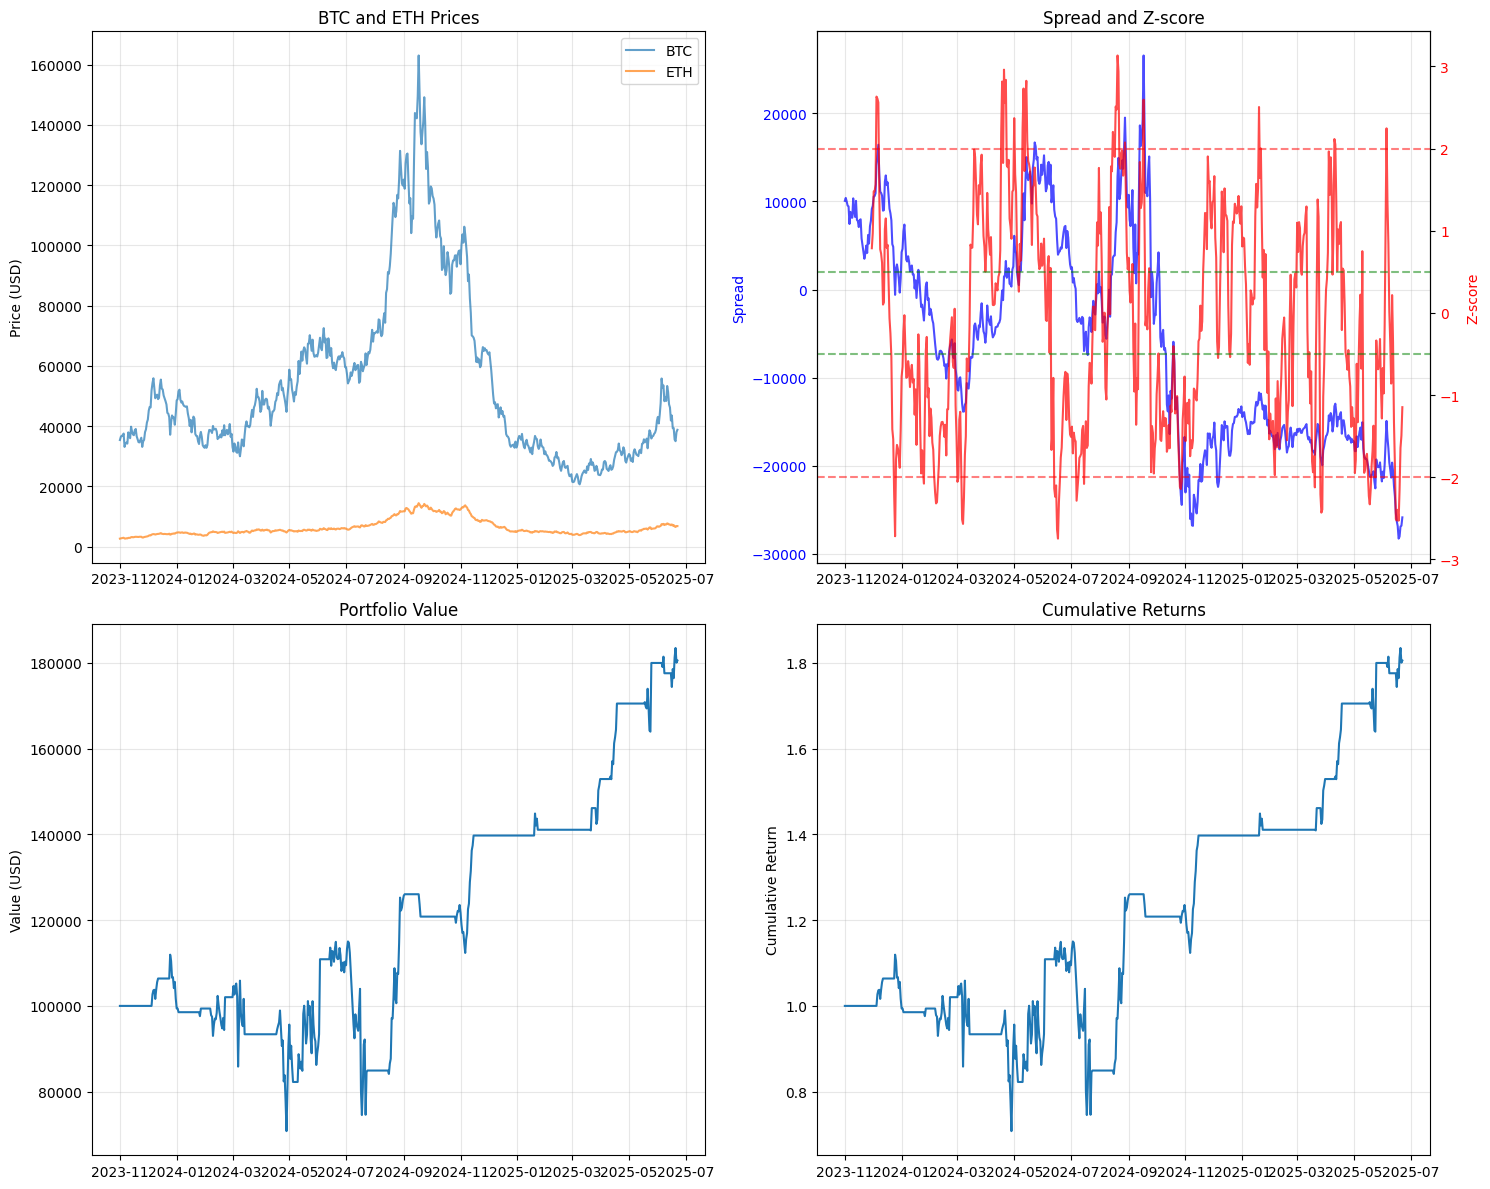

In [23]:
# Example usage and demonstration
def demonstrate_strategy():
    """
    Demonstrate the CNN-LSTM pairs trading strategy
    """
    print("CNN-LSTM Pairs Trading Strategy Demonstration")
    print("=" * 50)

    # Generate synthetic data for demonstration
    np.random.seed(42)
    dates = pd.date_range('2020-01-01', periods=2000, freq='D')

    # Synthetic cointegrated price series
    epsilon = np.random.normal(0, 0.02, 2000)  # Error term
    btc_base = np.cumsum(np.random.normal(0.001, 0.05, 2000))
    eth_base = 0.6 * btc_base + np.cumsum(epsilon)  # Cointegrated with BTC

    # Convert to price levels
    btc_prices = pd.Series(10000 * np.exp(btc_base), index=dates)
    eth_prices = pd.Series(500 * np.exp(eth_base), index=dates)

    # Initialize strategy
    strategy = CNNLSTMPairsTradingStrategy(
        lookback_window=14,
        entry_threshold=2.0,
        exit_threshold=0.5
    )

    # Split data for training and testing
    train_size = int(0.7 * len(btc_prices))
    btc_train = btc_prices[:train_size]
    eth_train = eth_prices[:train_size]
    btc_test = btc_prices[train_size:]
    eth_test = eth_prices[train_size:]

    print(f"Training model on {len(btc_train)} data points...")

    # Train the CNN-LSTM model
    try:
        history = strategy.train_model(btc_train, eth_train, epochs=50, validation_split=0.2)
        print("Model training completed!")
    except Exception as e:
        print(f"Model training failed: {e}")
        print("Proceeding with traditional pairs trading strategy...")

    # Backtest the strategy on test data
    print("Running backtest...")
    portfolio, spread, zscore = strategy.backtest_strategy(btc_test, eth_test, initial_capital=100000)

    # Calculate performance metrics
    metrics = strategy.calculate_performance_metrics(portfolio)

    print("\nStrategy Performance Metrics:")
    print("-" * 30)
    for metric, value in metrics.items():
        print(f"{metric}: {value}")

    # Plot results
    strategy.plot_results(btc_test, eth_test, portfolio, spread, zscore)

    return strategy, portfolio, metrics

if __name__ == "__main__":
    demonstrate_strategy()